# Maze Solver

A **maze** is a rectangular array of cells. The **agent** may move across the cells of the mase. By stepping into a cell, the agent receives a reward (or pays a penalty). Some cells are **terminal**, when stepping into a terminal cell the agent finishes the game (exits the maze). The **goal** of the agent is to maximize the total cummulative reward (minimize the total cummulative loss).

In addition to **regular** and **terminal** cells, there are also **walls**: walls are forbidden areas of the maze. The agent canot step onto a wall cell.

<div class="alert alert-block alert-info">
<b>The Assignment:</b> 
Implement the maze environment and develop optimal decision policy for moving across the maze.
</div>

We will implement:

## Assignments for Individual Work (Level 1)

1. Add TELEPORT CELLS and modify the code to accomodate this kind of cells also.
2. Implement value iteration algorithm using Q function instead of V function.
3. Implement policy iteration algorithm using both V and Q functions.

In all cases update, modify, and add visualization facilities to illustrate correctness of the implementation.

## Basic Imports

In [2465]:
from abc import ABC, abstractmethod
from typing import Iterable, Callable
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from random import random, choices

## The Maze

Let us implement the maze first, so that later we can implement solution algorithm(s).

We will start by implementing individual cells, and the we will collect them all within a single maze board.

### Implementing Individual Cells

In [2466]:
class Cell(ABC):
    """Abstract base class for all maze cells."""

    @abstractmethod
    def get_reward(self) -> float:
        """The reward an agent receives when stepping onto this cell."""
        pass

    def is_steppable(self) -> bool:
        """Checks if an agent can step onto this cell.

        Regular and terminal cells are steppable.
        Walls are not steppable.
        """
        return True

    def is_terminal(self) -> bool:
        """Checks if the cell is terminal.

        When stepping onto a terminal cell the agent exits
        the maze and finishes the game.
        """
        return False

    def has_value(self) -> bool:
        """Check if the cell has value.
        
        The value is defined for regular cells and terminal cells,
        but not for walls. 
        """
        return True

We will use the `Cell` class to derive all other cell classes. Please note that it may seem that `is_steppable` and `has_value` are essentially synonims, but this is not true in general.

Consider for example **teleport cells**. When stepping onto such a cell the agent is instantinuously transported into another, linked cell. Such a cell is different from the cell to which it is linked. It has a distinct geometrical location, and is steppable. However, from routing point of view it is just an alias for the linked cell, and so there is no reason for it to have a distinct value.

Let us now implement some basic types of cells:

In [2467]:
class RegularCell(Cell):
    """A common, non-terminal, steppable cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward


class TerminalCell(Cell):
    """A terminal cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

    def is_terminal(self) -> bool:
        return True

    def has_value(self) -> bool:
        return False


class WallCell(Cell):
    """A non-steppable cell."""

    def get_reward(self) -> float:
        return -5

    def is_steppable(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False
    

class TeleportCell(Cell):
    """A teleport cell."""

    def __init__(self, linked_cell: tuple[int, int] = None):
        self.linked_cell = linked_cell

    def get_reward(self) -> float:
        return -1

    def is_terminal(self) -> bool:
        return False

    def has_value(self) -> bool:
        # teleport has no value of its own
        return False   
    
    def teleport_to(self)-> tuple[int, int]:
        return self.linked_cell


### Implementing the Maze Board

The maze board is essentially a rectangular grid of cells. The board is not concerned with the type of individual cells, it is only interested in their relative arrangement.

In [2468]:
class MazeBoard:
    """Rectangular grid of cells representing a single mase."""

    @staticmethod
    def validate_cells(cells: Iterable[Iterable[Cell]]) -> tuple[int, int, list[list[Cell]]]:
        """
        Utility function used to validate the given double-iterable of of cells.
        
        Returns: tuple[int, int, list[list[Cell]]]
            int: number of rows
            int: number of columns
            list[list[Cell]]: double-list of cells from the input iterable
        """
        cells = [list(row) for row in cells] if cells else []
        if not cells:
            raise Exception("Number of rows in a board must be at least one.")
        if not cells[0]:
            raise Exception("There has to be at least one column.")
        rows_no = len(cells)
        cols_no = len(cells[0])
        for row in cells:
            if not row or len(row) != cols_no:
                raise Exception(
                    "Each row in a a board must have the same number of columns. ")
        return rows_no, cols_no, cells
    
    def __init__(self, cells: Iterable[Iterable[Cell]]):
        """
        Initialize the maze board from the given `cells`.

        The input double-iterable of cells is such that the elements of the outer
        iterable are considered to be rows. The input cells must satisfy certain
        conditions in order to be considered valid:

        * There must be at least one row.
        * All rows must be of the same length, which is at least one.
        """
        rows_no, cols_no, cells = MazeBoard.validate_cells(cells)
        self.cells = cells
        self.rows_no = rows_no
        self.cols_no = cols_no

    def __getitem__(self, key: tuple[int, int]) -> Cell:
        """Return cell in the given row and column."""
        r, c = key
        return self.cells[r][c]


### Creating and Visualizing Maze Boards

It would be nice to be able to randomly generate maze boards, and also to visualize them. It will enable us to effectively test our algorithms.

Let us first create a method for randomly generating boards. We will define this method to be very generic, allowing for different kind of cells to be generated with different probability.

In [2469]:
# Type-hint used to indicate a function which, when invoked, generates a cell.
CellGenerator = Callable[[], Cell]

def create_random_board(size: tuple[int, int], specs=list[tuple[float, CellGenerator]]) -> MazeBoard:
    """
    Generate a random cell.

    Args:
        size (float): Board size: height and width.
        specs (list[tuple[float, CellGenerator]]):
            List of tuples, each of which contains a weight factor and a Cell-generating function
            The weight-factor is proportional to the probability with thich the Cell-generator
            function will be invoked.
    """
    h, w = size
    weights = [w for w, _ in specs]
    generators = [g for _, g in specs]
    # The line below is a bit tricky...
    # `random_cell` is a function which returns a random cell once it has been invoked.
    # `choices` function returns a list of elements taken from `generators` with probabilities
    #    proportional to `weights`. The length of such list is set to 1. Therefore by indexing
    #    with `[0]` we are actually requiesting for the first and only element of that list.
    # In this way we obtained one such randomly selected generator.
    # We need to invoke it with `()` in order to actually get a cell.
    random_cell = lambda: choices(generators, weights, k=1)[0]()
    cells = [[random_cell() for i in range(w)] for j in range(h)]
    return MazeBoard(cells)

Let us furhter define a function that will help us visualize maze boards.

In [2470]:
def default_cell_color(cell: Cell) -> tuple[int, int, int]:
    if isinstance(cell, TeleportCell):
        return (255, 0, 255)         #Teleport cell - pink
    if isinstance(cell, RegularCell): 
        if cell.get_reward() == -0.5:
            return (255, 255, 255) # Regular cell - white
        else:
            return (255, 0, 0) # Regular cell with penalty - red
    elif isinstance(cell, WallCell):
        return (0, 0, 0) # Wall cell - black
    else:
        return (0, 0, 255) # Terminal cell - blue

def draw_board(board: MazeBoard, color = default_cell_color, pos: tuple[int, int] = None, ax=None, drawTeleportDest = False):
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8) 
    teleport_destinations = {}

    for i in range(board.rows_no):
        for j in range(board.cols_no):
            cell = board[i,j]
            board_img[i, j, :] = color(board[i, j])
            # Check if the cell is a TeleportCell
            if isinstance(cell, TeleportCell):
                teleport_destinations[(i, j)] = cell.linked_cell
    if drawTeleportDest:
        # Draw teleport destinations
        for teleport_cell, dest_cell in teleport_destinations.items():
            dx = dest_cell[1] - teleport_cell[1]
            dy = dest_cell[0] - teleport_cell[0]
            #Purple arrows show us where the teleport cell takes us
            ax.arrow(teleport_cell[1], teleport_cell[0], dx, dy, head_width=0.1, head_length=0.1, fc='purple', ec='purple')
    if pos is not None:
        row, col = pos
        ax.text(col-0.1, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)

### Testing Maze Board Generation and Visualization

In [2471]:
# This will be used as the default specification for the generator...
# It requires that the reqular cells with reward -1 are 7 times more likely than
# regular cells with higher penalty, walls and terminal cells.

DEFAULT_SPECS = [
    (8, lambda: RegularCell(-0.5)),    #8/14 chance
    (2, lambda: RegularCell(-10)),   #2/14 chance
    (2, lambda: WallCell()),         #2/14 chance
    (1, lambda: TerminalCell(20)),   #1/14 chance
    (1, lambda: TeleportCell())    #1/14 chance
]

Let's create a random board with Teleport cells and visualize it 

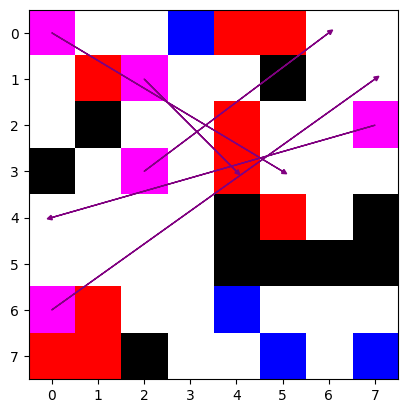

In [2472]:
board = create_random_board(size=(8, 8), specs=DEFAULT_SPECS)
# Find all steppable cells(excluding other teleport cells)
steppable_cells = []
for r in range(board.rows_no):
    for c in range(board.cols_no):
        if board[r, c].is_steppable() and not isinstance(board[r, c], TeleportCell):
            steppable_cells.append((r, c))

# For each Teleport cell, we will assign one random cell from steppable_cells
for r in range(board.rows_no):
    for c in range(board.cols_no):
        cell = board[r, c]
        if isinstance(cell, TeleportCell):
            cell.linked_cell = choices(steppable_cells, k=1)[0]

draw_board(board, drawTeleportDest=True)

### Maze as an MDP Environment

We will now wrap the maze board within a MDP environment which we will be used within our Dynamic Programming procedure.

In [2473]:
# Let us first enumerate the possible actions for better readability.
RIGHT = 0
UP = 1
LEFT = 2
DOWN = 3

# The following lus is used only to provide human-readable form of each action
ACTIONS = ["RIGHT", "UP", "LEFT", "DOWN"]

In [ ]:
class MazeEnvironment:
    #Maze Environment WITH Teleport Cells
    """Wrapper for a maze board that behaves like an MDP environment.
    
    This is a callable object that behaves like a deterministic MDP state
    transition function: given the current state and action, it returns the
    following state and reward.

    In addition, the environment object is capable of enumerating all possible
    states and all possible actions. For a given state it is also capable of
    deciding if the state is terminal or not.
    """

    def __init__(self, board: MazeBoard):
        """Initialize the enviornment by specifying the underlying maze board."""
        self.board = board


    def validate_position(self, row, col):
        """A utility function that validates a position."""
        if row < 0 or row >= self.rows_no:
            raise Exception("Invalid row position.")
        if col < 0 or col >= self.cols_no:
            raise Exception("Invalid column position.")
        if not self.board[row, col].is_steppable():
            raise Exception("Invalid position: unsteppable cell.")
        return r, c

    def move_up_from(self, row: int, col: int) -> tuple[int, int]:
        if row != 0 and self.board[row-1, col].is_steppable():
            return row-1, col
        else:
            return row, col

    def move_down_from(self, row: int, col: int) -> tuple[int, int]:
        if row != self.board.rows_no-1 and self.board[row+1, col].is_steppable():
            return row+1, col
        else:
            return row, col

    def move_left_from(self, row: int, col: int) -> tuple[int, int]:
        if col != 0 and self.board[row, col-1].is_steppable():
            return row, col-1
        else:
            return row, col

    def move_right_from(self, row: int, col: int) -> tuple[int, int]:
        if col != self.board.cols_no-1 and self.board[row, col+1].is_steppable():
            return row, col+1
        else:
            return row, col

    def move_from(self, row: int, col: int, action: int) -> tuple[int, int]:
        if action == RIGHT:
            return self.move_right_from(row, col)
        elif action == UP:
            return self.move_up_from(row, col)
        elif action == LEFT:
            return self.move_left_from(row, col)
        elif action == DOWN:
            return self.move_down_from(row, col)
        else:
            raise Exception("Invalid direction.")

    def __call__(self, state: tuple[int, int], action: int) -> tuple[tuple[int, int], float, bool]:
        row, col = state
        new_row, new_col = self.move_from(row, col, action)
        new_cell = self.board[new_row, new_col]

        # We will assign a large penalty for hitting into Wall cells and the borders of the board
        # If new coordinates are the same as the old ones, the agent has hit a Wall cell or border
        if (new_row, new_col) == (row, col):
            penalty = -10 
            return (new_row, new_col), penalty, False

         # Check if the new cell is a teleport cell
        if isinstance(new_cell, TeleportCell):
            # Teleport to a random steppable cell (excluding current position and walls)
            if new_cell.linked_cell is not None:
                new_row, new_col = new_cell.linked_cell 
                new_cell = self.board[new_row, new_col] 
            else:
                # Fallback if it's not defined
                pass

            '''if steppable_cells:
                new_row, new_col = random.choice(steppable_cells)
                new_cell = self.board[new_row, new_col]  #transport to new cell '''


        reward = new_cell.get_reward()
        is_terminal = new_cell.is_terminal()
        return (new_row, new_col), reward, is_terminal

    def get_states(self):
        states = []
        for r in range(self.board.rows_no):
            for c in range(self.board.cols_no):
                if self.board[r, c].is_steppable():
                    states.append((r, c))
        return states

    def is_terminal(self, s):
        return self.board[s[0], s[1]].is_terminal()

    def get_actions(self):
        return [RIGHT, UP, LEFT, DOWN]

Let us test the MDP environment. This will also enable us to understand better the manner in which the environment object is intended to be used.

### Testing the Maze Environment

Let us test the environment by issuing several commands and observing the result.

In [2475]:
env = MazeEnvironment(board)

K0: Teleport from (0, 0) to (3, 5)


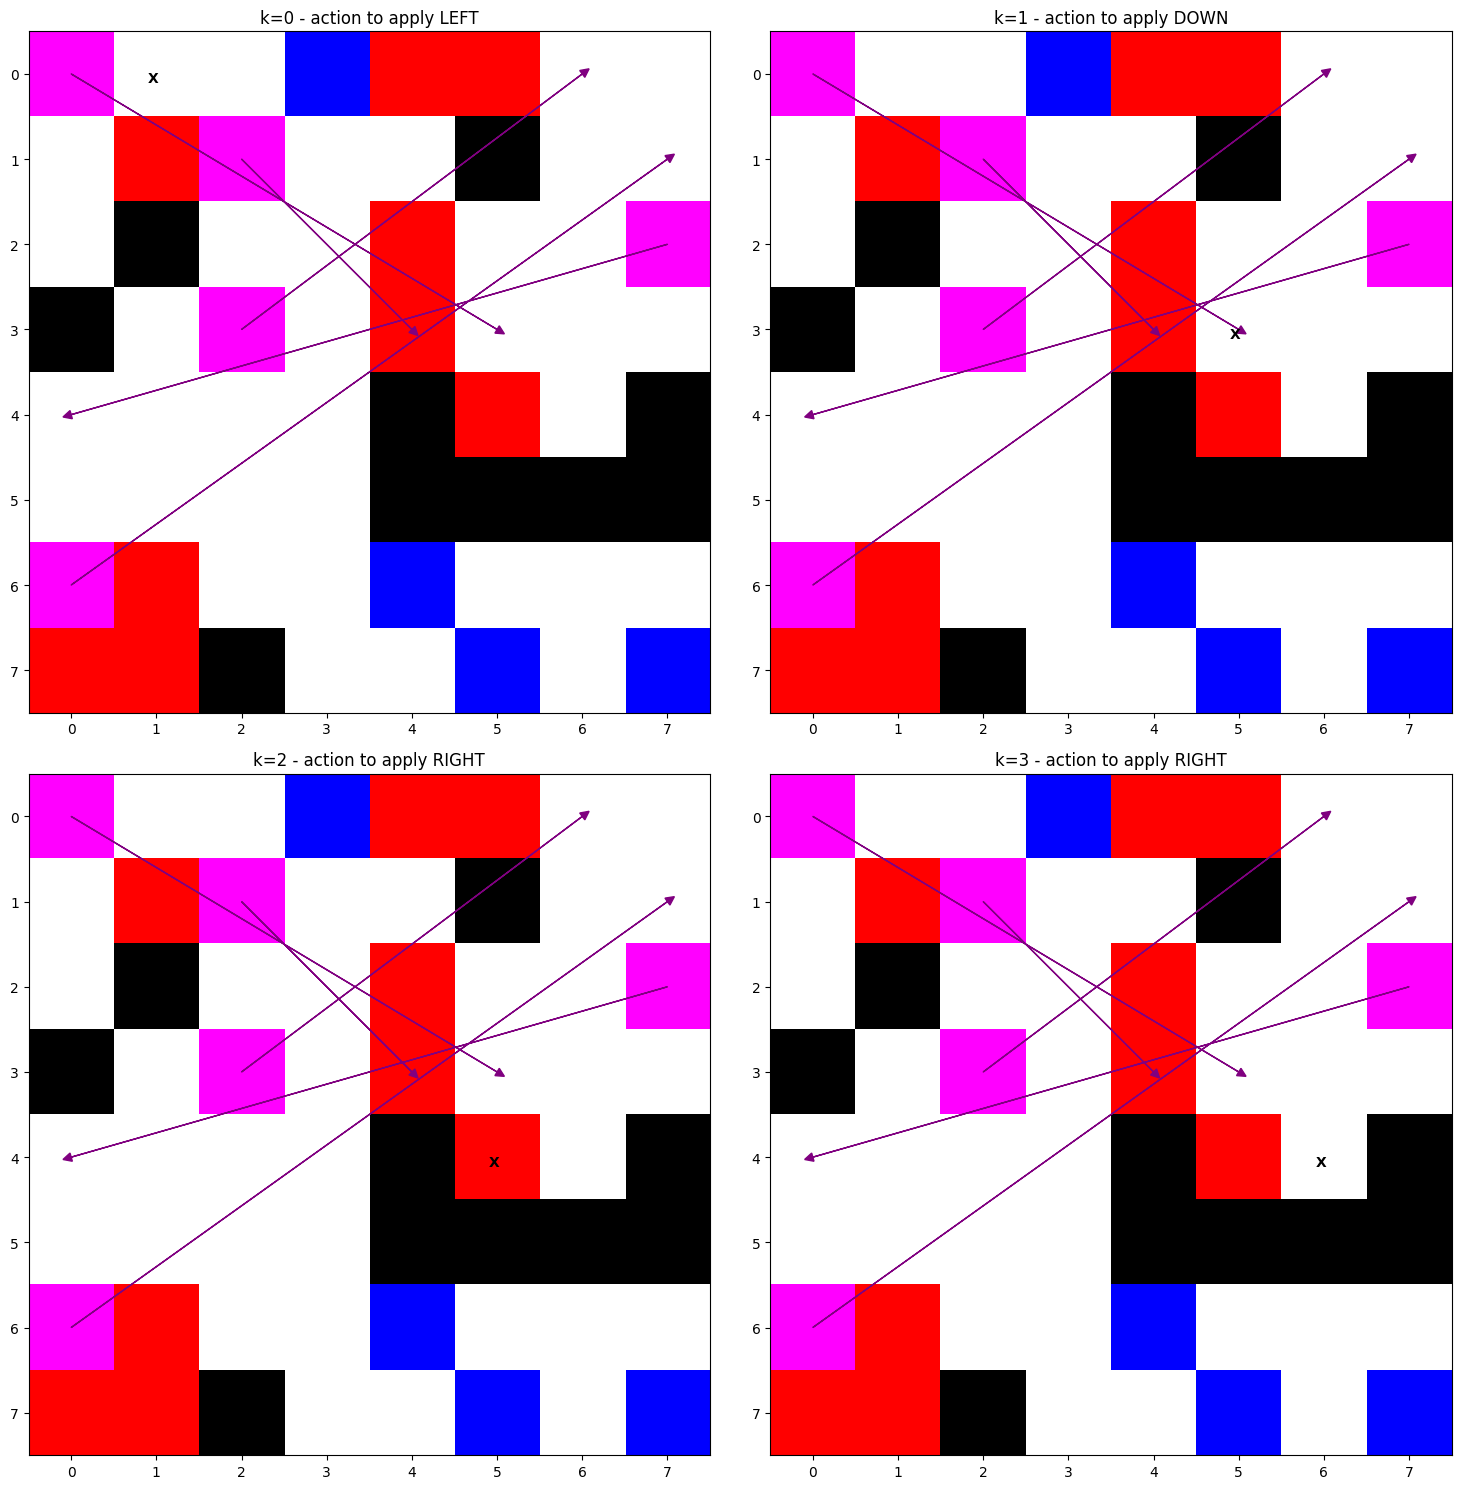

In [2476]:
# Let's start from the (0,1) position and test a few actions
state = (0, 1)
actions = [LEFT, DOWN, RIGHT, RIGHT]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes = axes.flatten()
axes

for k, a in enumerate(actions):
    ax = axes[k]
    draw_board(board, pos=state, ax=ax, drawTeleportDest=True)
    ax.set_title(f"k={k} - action to apply {ACTIONS[a]}")

    row, col = state
    landed_on = env.move_from(row, col, a)
    new_state, reward, terminal = env(state, a)
    
    # If the agent steps on a Teleport cell, he needs to be teleported to it's linked cell
    if isinstance(board[landed_on], TeleportCell):
        print(f"K{k}: Teleport from {landed_on} to {new_state}")
    
    state = new_state
    if terminal:
        break

plt.tight_layout()
plt.show()

## Value Iteration Algorithm

Let us now implement the **asynchronous version** of the **VALUE ITERATION ALGORITHM**. This algorithm will enable us to compute optimal state values for each state.

For the homework assignment, we will implement the value iteration algorith using Q function instead of V function

In [2477]:

def update_state_action_value(env: MazeEnvironment, s, a, q, gamma):
    """ Update Q value of the given state and action.
    Args:
        env (MazeEnvironment): The environment to work on.
        s : The state (cell position).
        a : Action (left, right, down, up)
        q : Q values of actions in states
        gamma : discount factor.
    """
    s_new, r, _ = env(s, a)   #Maze Environment returns the position(row,col) which is the state, reward and also is_terminal
    opt_q = max(q[s_new].values())
    optimal = r + gamma*opt_q
    return optimal

In [2478]:
def async_update_all_action_values(env: MazeEnvironment, q, gamma):
    """Update Q values of all states and actions.
    
    Args:
        env (MazeEnvironment): The environment to work on.
        q : Q values
        gamma : discount factor.
    """
    for s in env.get_states():
        if env.is_terminal(s):
            continue
        for a in env.get_actions():
            if not env.is_terminal(s):
                q[s][a] = update_state_action_value(env, s, a, q, gamma)
    return copy(q)

In [ ]:
import random
def init_action_values(env):
    """Initialize Q-values optimistically."""
    q_values = {s: {a: 0.0 for a in env.get_actions()}  #initialize them to 0
                for s in env.get_states()}
    #q_values = {s: {a: -5*random.random() for a in env.get_actions()} for s in env.get_states()}
    
    for s in q_values:
        if env.is_terminal(s):
            for a in q_values[s]:
                q_values[s][a] = 0

    return q_values

It is also convenient to have a method for visualization of values.

In [2480]:
def draw_q_values(env, q, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s in q:
        v = max(q[s].values())
        ax.text(s[1]-0.25, s[0]+0.1, f"{v:.1f}")


Let us test the above methods by visualizing initial state values, and also the evolution of state values through several initial steps.

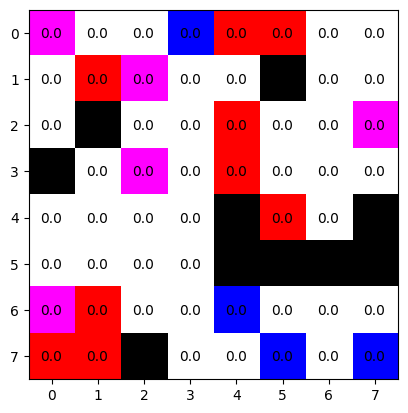

In [2481]:
q_values = init_action_values(env)
draw_q_values(env, q_values)

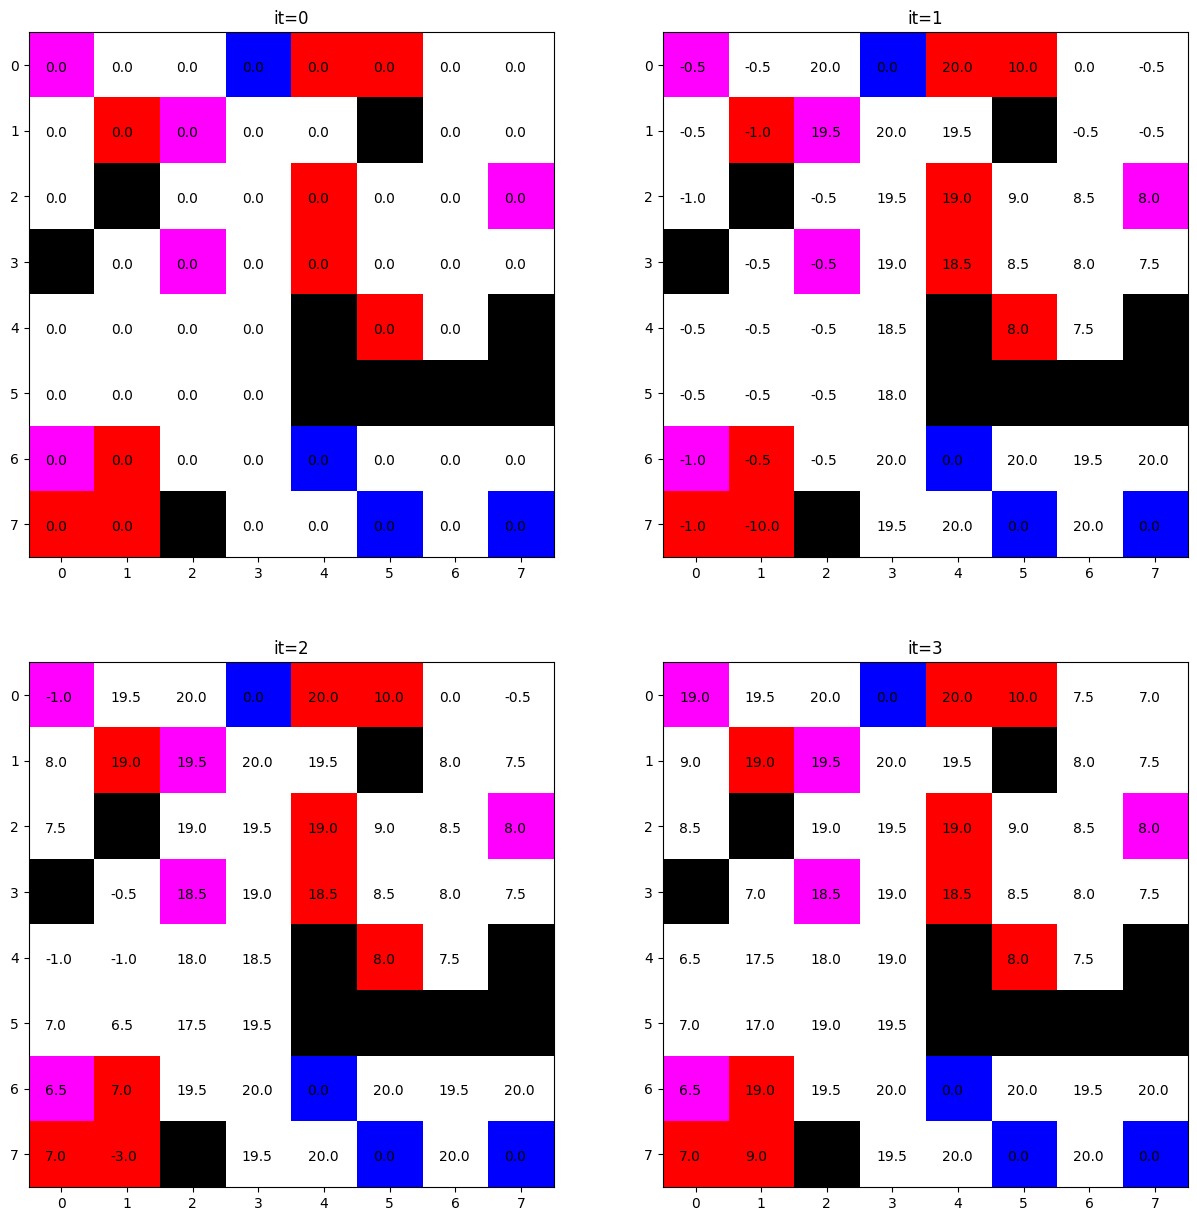

In [2482]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()
values = init_action_values(env)
for k in range(nrows*ncols):
    draw_q_values(env, values, ax)
    axes[k].set_title(f"it={k}")
    draw_q_values(env, values, ax=axes[k])
    values = async_update_all_action_values(env, values, 1.0)

We are finally ready to implement the value iteration algorithm.

In [2483]:
def q_value_iteration(env, gamma, eps, q0=None, maxiter=300):
    q_values = q0 if q0 is not None else init_action_values(env)
    v = {s: max(q_values[s].values()) for s in env.get_states()}
    for k in range(maxiter):
        new_q = async_update_all_action_values(env, q_values, gamma)
        new_v = {s: max(new_q[s].values()) for s in env.get_states()}
        err = max(abs(new_v[s] - v[s]) for s in v)
        if err < eps:
            return new_q, k
        q_values = new_q
        v = new_v
    return q_values, k
def value_iteration(env, gamma, eps, v0=None, maxiter=100):
    v = v0 if v0 is not None else init_values(env)
    for k in range(maxiter):
        nv = async_update_all_values(env, values, gamma)
        err = max([abs(nv[s] - v[s]) for s in v])
        if err<eps:
            return nv, k
        v = nv
    return v, k 
   

Let us test the algorithm by 

Text(0.5, 1.0, 'Converged after 9 iterations')

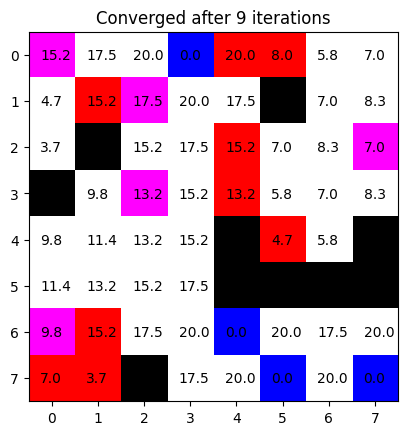

In [2484]:
q_values, iterations = q_value_iteration(env, gamma=0.9, eps=0.01)
draw_q_values(env, q_values)
plt.title(f"Converged after {iterations} iterations")


## Finding and Visualizing Optimal Decision Policy Using Both Q and V Function

We can now compute the full optimal policy

It is also helpfull to have a function for visualization of policies.

In [2485]:
def action_symbol(a):
    if a == RIGHT:
        return "→"
    elif a==UP:
        return "↑"
    elif a==LEFT:
        return "←"
    elif a == DOWN:
        return "↓"
    else:
        raise "Unknown action"

def draw_policy(env, policy, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax, drawTeleportDest=True)
    for s, a in policy.items():
        # Check if the cell is a Teleport cell
        if isinstance(env.board[s[0], s[1]], TeleportCell):
            continue  # If the cell is a Teleport cell, don't draw action symbol
        ax.text(s[1]-0.25, s[0]+0.1, action_symbol(a))

Policy Iteration using V function

In [2486]:
def init_values(environment):
    """Initialize state values."""
    values = {state: -5*random.random() for state in environment.get_states()}
    
    for state in values:
        if environment.is_terminal(state):
            values[state] = 0
    
    return values

def init_policy(environment):
    """Initialize random policy."""
    policy = {}
    
    for state in environment.get_states():
        if not environment.is_terminal(state):
            policy[state] = choices(environment.get_actions(), k=1)[0]
    
    return policy

In [2487]:
def policy_evaluation_v(env, policy, gamma, eps=0.01, max_iterations=1000):
    """Evaluate policy using V-function."""
    values = init_values(env)

    for iteration in range(max_iterations):
        new_values = copy(values)
        
        for state in env.get_states():
            if not env.is_terminal(state):
                action = policy[state]
                state_new, reward, _ = env(state, action)
                new_values[state] = reward + gamma * values[state_new]
        
        error = max([abs(new_values[state] - values[state]) for state in values])
        
        if error < eps:
            break
        
        values = new_values
    
    return values

In [2488]:
def policy_improvement_v(env, v_values, gamma):
    """Improve policy using V-function."""
    new_policy = {}
    
    for state in env.get_states():
        
        if not env.is_terminal(state):
            action_values = []
            
            for action in env.get_actions():
                state_new, reward, _ = env(state, action)
                action_values.append(reward + gamma * v_values[state_new])
            
            new_policy[state] = np.argmax(action_values)
    
    return new_policy

In [2489]:
def policy_iteration_with_v(env, gamma, eps=0.01, max_iterations=1000):
    """Policy iteration using V-function."""
    policy = init_policy(env)
    
    for iteration in range(max_iterations):
        # Policy Evaluation
        values = policy_evaluation_v(env, policy, gamma, eps)
        
        # Policy Improvement
        new_policy = policy_improvement_v(env, values, gamma)
        
        # Check for convergence
        if all(policy.get(state) == new_policy.get(state) for state in policy):
            return new_policy, values, iteration
        
        policy = new_policy
    
    return policy, values, iteration

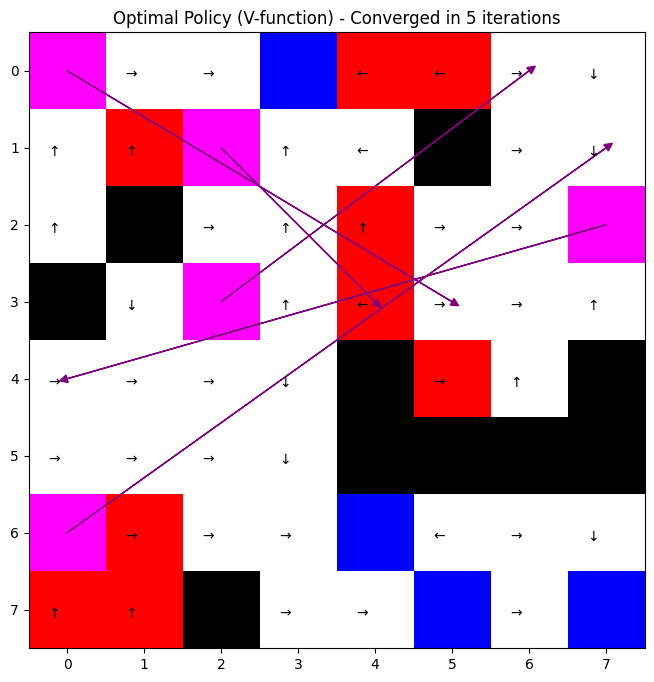

In [2490]:
gamma = 0.9  # Discount factor
eps = 0.001  # Convergence threshold

# Obtain the optimal policy using policy iteration with V-function
optimal_pi, final_values, it_count = policy_iteration_with_v(env, gamma, eps)

# Vizualize the policy
fig, ax = plt.subplots(figsize=(8, 8))
draw_policy(env, optimal_pi, ax=ax)
ax.set_title(f'Optimal Policy (V-function) - Converged in {it_count} iterations')
plt.show()


Policy Iteration using Q function

In [ ]:
def policy_evaluation_q(env, policy, gamma, eps=0.01, max_iterations=2000):
    """
    Policy Evaluation using Q-function.
    Q^pi(s,a) = R(s,a,s') + gamma * V^pi(s')
    V^pi(s') = Q^pi(s', pi(s'))
    """
    q_values = init_action_values(env)
    
    for iteration in range(max_iterations):
        delta = 0
        new_q_values = {s: {} for s in env.get_states()}
        
        for s in env.get_states():
            if env.is_terminal(s):
                for a in env.get_actions():
                    new_q_values[s][a] = 0
                continue
            
            for a in env.get_actions():
                s_new, r, is_terminal = env(s, a)
                
                if is_terminal:
                    target = r
                else:
                    a_policy = policy[s_new]
                    target = r + gamma * q_values[s_new][a_policy]
                
                new_q_values[s][a] = target
                delta = max(delta, abs(target - q_values[s][a]))
        
        q_values = new_q_values
        
        if delta < eps:
            break
    
    return q_values


'def policy_evaluation_q(env, policy, gamma, eps=0.01, max_iterations=2000):\n    """Evaluate policy using Q-function."""\n    q_values = init_action_values(env)\n\n    for iteration in range(max_iterations):\n        new_q_values = copy(q_values)\n\n        for s in env.get_states():\n            if not env.is_terminal(s):\n                for a in env.get_actions():\n                    s_new, r, _ = env(s,a)\n                    if env.is_terminal(s_new):\n                        new_q_values[s][a] = r\n                    else:\n                        a_next = policy[s_new]\n                        new_q_values[s][a] = r + gamma * q_values[s_new][a_next]\n\n        error = max([abs(new_q_values[s][a] - q_values[s][a]) for s in q_values for a in q_values[s]])\n\n        if error < eps:\n            break\n\n        q_values = new_q_values\n\n    return q_values '

In [2492]:
def policy_improvement_q(env, q_values, gamma):
    """Improve policy using Q-function."""
    new_policy = {}
    
    for s in env.get_states():
        if not env.is_terminal(s):
            new_policy[s] = max(q_values[s], key=q_values[s].get)
    
    return new_policy

In [2493]:
def policy_iteration_with_q(env, gamma, eps=0.01, max_iterations=2000):
    """Policy iteration using Q-function."""
    policy = init_policy(env)
    
    for iteration in range(max_iterations):
        # Policy Evaluation
        q_values = policy_evaluation_q(env, policy, gamma, eps)
        
        # Policy Improvement
        new_policy = policy_improvement_q(env, q_values, gamma)
        
        # Check for convergence
        if all(policy.get(state) == new_policy.get(state) for state in policy):
            return new_policy, q_values, iteration
        
        policy = new_policy
    
    return policy, q_values, iteration

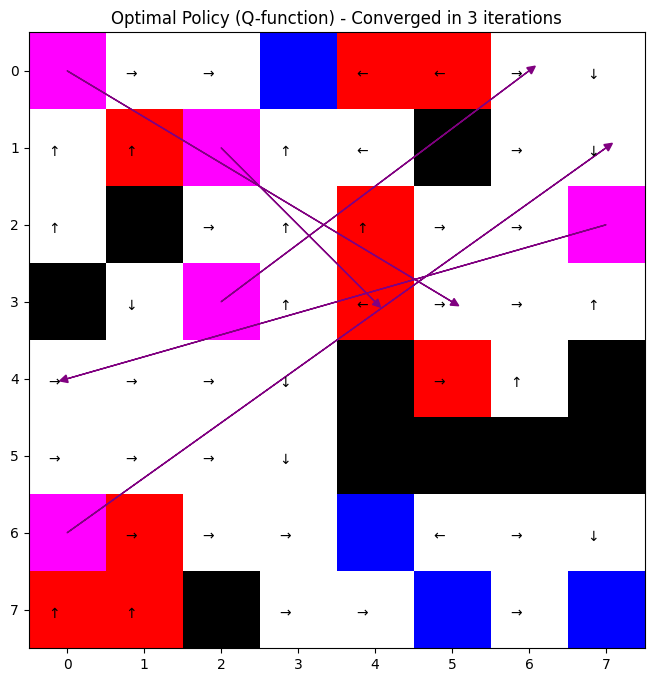

In [2494]:
gamma = 0.9  # Discount factor
eps = 0.001  # Convergence threshold

# Obtain the optimal policy using policy iteration with Q-function
optimal_pi, final_values, it_count = policy_iteration_with_q(env, gamma, eps)

# Vizualize the policy
fig, ax = plt.subplots(figsize=(8, 8))
draw_policy(env, optimal_pi, ax=ax)
ax.set_title(f'Optimal Policy (Q-function) - Converged in {it_count} iterations')
plt.show()